In [1]:
#import os

###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
###
#from tqdm import tqdm
#from sklearn.model_selection import train_test_split
#
#from PIL import Image
#
#import torch
#from torch.utils.data import DataLoader
#import torchvision.transforms as transforms

#from torch import nn
###
#from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
#from transformers import AutoModel, AutoTokenizer
#from transformers import TrainingArguments, Trainer
#from transformers import default_data_collator

[nltk_data] Downloading package punkt to /home/andrew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dataset

In [2]:
folder = "/media/andrew/HD-GDU3/498/"
imageset_folder = "complete_imageset/"
dataset_folder = "preprocessed_single_image_text/"
reports = "raw.csv"
text_loc = folder + dataset_folder + reports
image_loc = folder + imageset_folder
#md_location = folder + meta_data
#meta_reports = pd.read_csv(md_location)
#sample = meta_reports.head()
#sample

## Mimic Reports

In [4]:
#raw = pd.read_csv('raw.csv')
raw = pd.read_csv(text_loc)
print (f'patient records: {text_loc}')
print (f"records: {len(raw)}")
raw.head()

patient records: /media/andrew/HD-GDU3/498/preprocessed_single_image_text/raw.csv
records: 76112


,subject_id,study_id,path,content,cleaned_content,IMPRESSION:,FINDINGS:,WET READ:,CONCLUSION:
0,10000935,50578979,files/p10/p10000935/s50578979.txt,FINAL REPORT\...,"HISTORY: Leukocytosis, low-grade temperature, ...",IMPRESSION: 1. Low lung volumes and mild pulmo...,FINDINGS: Lung volumes remain low. There are i...,NaN,NaN
1,10000935,58219844,files/p10/p10000935/s58219844.txt,FINAL REPORT\...,HISTORY: Dyspnea and history of lung cancer. T...,IMPRESSION: Innumerable pulmonary metastases. ...,FINDINGS: Lung volumes are low. This results i...,NaN,NaN
2,10000980,51967283,files/p10/p10000980/s51967283.txt,FINAL REPORT\...,INDICATION: -year-old female with shortness of...,IMPRESSION: Right upper lobe pneumonia or mass...,NaN,NaN,NaN
3,10000980,58206436,files/p10/p10000980/s58206436.txt,WET READ: ___ ___ ___ 6:47 AM\n 1. New mild ...,WET READ: 6:47 AM 1. New mild pulmonary edema ...,IMPRESSION: 1. New mild pulmonary edema with p...,FINDINGS: In comparison to study performed on ...,WET READ: 6:47 AM 1. New mild pulmonary edema ...,NaN
4,10001217,58913004,files/p10/p10001217/s58913004.txt,WET READ: ___ ___ ___ 11:18 PM\n It is diffi...,WET READ: 11:18 PM It is difficult to determin...,NaN,FINDINGS: As compared to the previous radiogra...,WET READ: 11:18 PM It is difficult to determin...,NaN


In [5]:
filenames = pd.read_csv('image_locations.csv')
#filenames = pd.read_csv('image_locations.csv')
print (f'Total images found {len(filenames)}')

Total images found 82263


### Feature Selection
Identify only the features we wish to include in the new dataset and rename

In [6]:
# Create a dictionary of column names and feature names
feature_dict = {
    'subject_id': 'subject',
    'study_id': 'study',
    'IMPRESSION:': 'impression', 
    'FINDINGS:': 'findings',
    'WET READ:': 'wet_read',
    'CONCLUSION:': 'conclusion'
}

In [7]:
data = raw[feature_dict.keys()].copy().rename(columns=feature_dict)

In [8]:
data.head()

,subject,study,impression,findings,wet_read,conclusion
0,10000935,50578979,IMPRESSION: 1. Low lung volumes and mild pulmo...,FINDINGS: Lung volumes remain low. There are i...,NaN,NaN
1,10000935,58219844,IMPRESSION: Innumerable pulmonary metastases. ...,FINDINGS: Lung volumes are low. This results i...,NaN,NaN
2,10000980,51967283,IMPRESSION: Right upper lobe pneumonia or mass...,NaN,NaN,NaN
3,10000980,58206436,IMPRESSION: 1. New mild pulmonary edema with p...,FINDINGS: In comparison to study performed on ...,WET READ: 6:47 AM 1. New mild pulmonary edema ...,NaN
4,10001217,58913004,NaN,FINDINGS: As compared to the previous radiogra...,WET READ: 11:18 PM It is difficult to determin...,NaN


In [9]:
def process_text(text, exclude = None):
    '''
    processes the sentences to remove special characters, convert to lowercase, etc.
    
    text: text to be processed
    exclude: words to be removed
    punctuation: boolean to add period at end of each sentence
    '''

    # Remove the Headings from the text
    for k in exclude:
        text = text.replace(k, '')

    # Remove all timestamps
    timestamp = re.compile(r'\d+\:\d{2}\s?(?:AM|PM|am|pm)\s')
    text = timestamp.sub('', text)

    # Remove all numbered lists.
    numbered_lists = re.compile(r'\d+.\s')
    text = numbered_lists.sub('', text)

    # Remove all extra whitespaces
    text = re.sub(' +', ' ', text).strip()

    #m = re.sub(r'\b[A-Z]+: ', '', m)
    
    # Convert all to lowercase
    text = re.sub(r'\d+.', '', text).lower()

        
    return (text)

In [53]:
def preprocess_dataset(data, images, features, name='dataset.csv', save=False):
    '''
    Creates a dataframe of sentences from the clinical reports which 
    have been preprocessed using the rules above
    
    data: dataset of reports
    images: csv containing subject/study and image location
    features: feature dictionary including headings to be removed
    name: name to save the dataset to disk
    save: boolean to state if save should be performed
    '''
    
    counter = 0
    
    corpus = []
    
    printout = []
    
    for observation in tqdm(range(len(data))):
        subject_id = data['subject'][observation]
        study_id = data['study'][observation]

        try: 
            #lookup the image... if an image is not found for the study, we will skip that report.
            file_id = images[images['study_id'] == study_id]['resized_file_name'].values[0]
                # For each of the features in our list:
            for category in list(features.values())[2:]:
                    # If it is a string rather than a bool i.e., NaN,
                if isinstance(data[category][observation], str):
                    # Preprocess the report
                    reported_observation = process_text(
                                    text = data[category][observation],
                                    exclude = list(features.keys())
                                )
                    
                    # Break into sentences
                    sentences = sent_tokenize(reported_observation)
                    
                    # For each sentence, create a new record
                    for sentence in sentences:

                        container = {
                                'subject':subject_id, 
                                'study':study_id,
                                'type':category,
                                'value':re.sub(r"[^a-zA-Z0-9 ]", "", sentence), #need more efficient option
                                'file_name': file_id,
                                'length': len(sentence.split()),
                                'note':None,
                                }
                        
                        corpus.append(container)
       
        except Exception as e: 
            #print(e)
            printout.append(f'Error processing subject/study {subject_id}/{study_id}')
            counter += 1
        
    print ("")
    print (f'Total not found: {counter}')
    print (printout)
    
    corpus = pd.DataFrame(corpus)
    corpus = corpus.drop(corpus[corpus['value'] == ''].index, inplace = False)
    corpus['candidate'] = True
    
    if save:
        corpus.to_csv(name, index=False)
        print (f'Corpus saved to {name}')

    return (corpus)

In [54]:
def parse_dataset(name, run=True, save = False):
    if run:
        dataset = preprocess_dataset(
            data = data, 
            images = filenames, 
            features = feature_dict, 
            name = name, 
            save = save
        )
    else:
        dataset = pd.read_csv(name)
    
    print (f'Total records: {len(dataset)}')
    
    return (dataset)    

In [55]:
dataset = parse_dataset(name='dataset.csv', run=True, save=True)

100%|███████████████████████████████████████████████████████████████████████████████| 76112/76112 [00:40<00:00, 1871.95it/s]



Total not found: 1
['Error processing subject/study 10000980/58206436']
Corpus saved to dataset.csv
Total records: 470619


In [49]:
dataset.loc[1231]['value'] == ''

True

# Stop Words

In [956]:
exclusion_list = [
    'as compared to the previous',
    'dr. ',
    'doctor',
    'telephone',
    #'change',
    'no change.',
    'yesterday',
    'no relevant change',
    'prior study',
]

In [957]:
def filter_pairs(db, filename = 'dataset.csv', exclusion=exclusion_list, save=True):
    '''
    Filters out sentences based on exlusion list'
    '''
    
    for term in exclusion:
        print (f'''The term or phrase '{term}' has been removed.''')
        #first search for the term in all activate candidate cells and record rule
        db.loc[(db['candidate'] == True) & (db['value'].str.contains(term)), "note"] = f"Removal: {term}"
        # if the note contains an exlusion rule, set the candidate flag to False
        db.loc[(db['candidate'] == True) & (db['value'].str.contains(term)), "candidate"] = False
        #complete.loc[complete['value'].str.contains(term), "note" = f"{term}"
        #for term in exclusion:
        #complete.loc[complete['note'] == True, "candidate"] = False
        #complete.loc[complete['value'].str.contains(term), "note"] = f"Removal: {term}"

    if save:
        
        refined_name = 'refined_'+filename
        rejected_name = 'rejected_'+filename
        all_pairs = 'all_'+filename
        
        print ("")
        
        db[db['candidate'] == True].to_csv(refined_name, index=False)
        print (f'Candidates saved to csv: {refined_name}')
        
        db[db['candidate'] == False].dropna().sort_values(by=['note']).to_csv(rejected_name, index=False)
        print (f'Rejected saved to csv: {rejected_name}')
        
        db.to_csv(all_pairs, index=False)
        print (f'All pairs saved to csv: {all_pairs}')
    
    return db[db['candidate'] == True]

In [958]:

candidates = filter_pairs(
    db = dataset
    )

The term or phrase 'as compared to the previous' has been removed.
The term or phrase 'dr. ' has been removed.
The term or phrase 'doctor' has been removed.
The term or phrase 'telephone' has been removed.
The term or phrase 'no change.' has been removed.
The term or phrase 'yesterday' has been removed.
The term or phrase 'no relevant change' has been removed.
The term or phrase 'prior study' has been removed.

Candidates saved to csv: refined_dataset.csv
Rejected saved to csv: rejected_dataset.csv
All pairs saved to csv: all_dataset.csv


In [961]:
candidates

,subject,study,type,value,file_name,length,candidate,note
0,10000935,50578979,impression,impression low lung volumes and mild pulmonary...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,24,True,NaN
1,10000935,50578979,findings,findings lung volumes remain low there are inn...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,57,True,NaN
2,10000935,58219844,impression,impression innumerable pulmonary metastases po...,10000935_58219844_88498b37-c21dc7ba-bc202800-b...,12,True,NaN
3,10000935,58219844,findings,findings lung volumes are low this results in ...,10000935_58219844_88498b37-c21dc7ba-bc202800-b...,93,True,NaN
6,10001217,58913004,wet_read,wet read it is difficult to determine the dist...,10001217_58913004_5e54fc9c-37c49834-9ac3b915-5...,43,True,NaN


# Create training dataset

In [650]:
def create_refined_pairs(db, debug = False, as_paragraph = True):
    #Create list of studies with candidate sentences
    studies = pd.unique(db['study'])
    #create empty dataframe
    training_pairs = pd.DataFrame(columns=['caption','image'])
    #for each study in the list.
    for study in tqdm(range(studies)):
        if debug: print (study)
        image = folder + db['file_name'][db.loc[db['study' ] == study].index[0]]
        if debug: print (image)
        # For each study, create a list of sentences
        container = []
        for sentence in db[db["study"] == study]['value']:
            if debug: print (sentence)
            container.append(sentence)
        #For each list of sentences, recreate a paragraph
        paragraph = ''
        for statement in container:
            paragraph += statement + " "
        if debug: print (paragraph)

        record = pd.DataFrame({
            'caption':paragraph,
            'image':image
            }, index=[0])

        training_pairs = pd.concat([record, training_pairs],ignore_index=True)
        #print (training_pairs)

    return training_pairs

In [651]:
NEW_DATASET = create_refined_pairs(db = complete[complete['candidate'] == True])

In [652]:
NEW_DATASET.dropna().to_csv('NEW_DATASET.csv', index=False)

In [ ]:
## OLD CODE

In [624]:
test['image'][0]

'/media/andrew/HD-GDU3/498/complete_imageset/10002013_58054149_81bca127-0c416084-67f8033c-ecb26476-6d1ecf60.jpg'

In [ ]:
def resest():
    complete = pd.read_csv('new_pairs_unrefined.csv)

In [571]:
for term in exclusion:
    complete.loc[complete['value'].str.contains(term), "candidate"] = False
    complete.loc[complete['value'].str.contains(term), "note"] = f"Removal: {term}"

### New Pairs Refined

In [578]:
complete[complete['candidate'] == True].to_csv('new_pairs_refined.csv', index=False)
complete[complete['candidate'] == True]

,subject,study,type,value,file_name,length,candidate,note
1,10000935,50578979,impression,new small right fissural pleural effusion.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,6,True,None
2,10000935,50578979,impression,no new focal opacities to suggest pneumonia.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,7,True,None
3,10000935,50578979,findings,lung volumes remain low.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,4,True,None
4,10000935,50578979,findings,there are innumerable bilateral scattered smal...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,21,True,None
6,10000935,50578979,findings,small pleural effusion in the right middle fis...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,10,True,None
...,...,...,...,...,...,...,...,...
471636,19999987,58621812,findings,portable supine ap view of the chest provided ...,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,20,True,None
471637,19999987,58621812,findings,the ng tube courses into the left upper abdomen.,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,9,True,None
471638,19999987,58621812,findings,there is bibasilar atelectasis.,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,4,True,None
471639,19999987,58621812,findings,heart and mediastinal contour appears grossly ...,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,7,True,None


### New Pairs Rejected

In [580]:
complete[complete['candidate'] == False].dropna().sort_values(by=['note']).to_csv('new_pairs_rejected.csv', index=False)
complete[complete['candidate'] == False].dropna()

,subject,study,type,value,file_name,length,candidate,note
0,10000935,50578979,impression,low lung volumes and mild pulmonary vascular c...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,10,False,Removal: change
5,10000935,50578979,findings,the cardiomediastinal silhouette and hilar con...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,8,False,Removal: change
20,10000935,58219844,findings,rib deformities within the right hemithorax is...,10000935_58219844_88498b37-c21dc7ba-bc202800-b...,12,False,Removal: change
24,10000980,51967283,impression,dr. communicated the above results to dr. at o...,10000980_51967283_943486a3-b3fa9ff7-50f5a769-7...,11,False,Removal: telephone
25,10001217,58913004,findings,"as compared to the previous radiograph, there ...",10001217_58913004_5e54fc9c-37c49834-9ac3b915-5...,20,False,Removal: change
...,...,...,...,...,...,...,...,...
471582,19999287,50000173,findings,compared to the prior study the et tube has be...,19999287_50000173_c8bbb9ff-ecb81ef7-a1a6cecf-f...,18,False,Removal: change
471583,19999287,50574077,impression,"as compared to the previous examination, there...",19999287_50574077_ef49bac7-16939860-5a4f182e-c...,11,False,Removal: as compared to the previous
471606,19999287,53255195,findings,the cardiomediastinal silhouette appears gross...,19999287_53255195_431c5823-ea54bba2-f21af1d4-4...,6,False,Removal: change
471608,19999287,58938059,impression,"as compared to the previous radiograph, there ...",19999287_58938059_2eb70dfe-52fa728e-a36e09be-e...,10,False,Removal: as compared to the previous


In [421]:
#complete.dropna().to_csv('new_pairs_unrefined.csv', index=False)

In [443]:
pivot = pd.pivot_table(complete, values = ['value'], index = ['study'], columns = ['type'], aggfunc='count', margins=True) #.to_csv('pivot.csv')
pivot = pd.read_csv('pivot.csv')

In [450]:
pivot.drop(pivot.tail(1).index,inplace=True)

In [457]:
pivot.drop(pivot.head(2).index,inplace=True)

In [562]:
print ("min",pivot['length.4'].astype(float).min())
print ("max", pivot['length.4'].astype(float).max())
print ("mean", pivot['length.4'].astype(float).mean())

min 1.0
max 452.0
mean 61.37042049934297


In [462]:
pivot

,Unnamed: 0,value,value.1,value.2,value.3,value.4
2,50000052,NaN,NaN,5.0,NaN,5
3,50000125,NaN,1.0,5.0,NaN,6
4,50000173,NaN,1.0,1.0,NaN,2
5,50000198,NaN,6.0,1.0,NaN,7
6,50001080,NaN,NaN,NaN,8.0,8
...,...,...,...,...,...,...
76097,59999463,NaN,NaN,3.0,NaN,3
76098,59999476,NaN,NaN,7.0,NaN,7
76099,59999516,NaN,NaN,10.0,NaN,10
76100,59999807,NaN,6.0,2.0,NaN,8


In [465]:
pivot['value.4'].astype(float).mean()

6.197647831800263

In [ ]:
## Impression, Finding, and WetRead are what we are looking for.
## Create Sentence Vectors for each of the sections, stripping out times.

In [ ]:
headings = ['FINDINGS:', 'IMPRESSION:', 'WET READ:']

In [ ]:
def create_vectors(x, db = sample, headings = headings):
    i = 0
    state = [0,0,0]
    for feature in headings:
        if isinstance(db[feature][x], str):
            state[i] = 1
            print (sent_tokenize(preptext(x, db = db, feature = feature, exclude = headings)))
        i += 1
    
    return (state)

In [ ]:
def combine_texts(observation, db, headings=headings, as_sentences = False):
    i = 0
    output = []
    state = [False, False, False]
    for feature in headings:
        if isinstance(db[feature][observation], str):
            state[i] = True
        i += 1
    
    if state[0] and state[1]: 
        for feature in ['FINDINGS:', 'IMPRESSION:']:
            output = output + sent_tokenize(preptext(observation, db = db, feature = feature, exclude = headings))
    else:
        for feature in headings:
            if isinstance(db[feature][observation], str):
                output = output + sent_tokenize(preptext(observation, db = db, feature = feature, exclude = headings))
    
    if not as_sentences:
        output = ' '.join(output)
        
    return output

In [ ]:
combine_texts(268, db=reports, as_sentences=False)

In [ ]:
## Create Training Set

In [ ]:
# Load Image Set

In [ ]:
def build_set(csv, subfolder, head=False, base_folder="/media/andrew/HD-GDU3/498/"):
    folder = base_folder + subfolder
    dataset = csv
    location = folder + dataset
    db = pd.read_csv(location)
    
    if head == True:
        db = db.head()
    
    return db

In [ ]:
def gen_name(observation, db):
    subject_id = db['subject_id'][observation]
    study_id = db['study_id'][observation]
    dicom_id = db['dicom_id'][observation]
    new_name = f'{subject_id}_{study_id}_{dicom_id}.jpg'
    
    return new_name

In [ ]:
def create_record(location, image, caption):
    record = pd.DataFrame({
        'caption':caption, 
        'image':location+image
        }, index=[0])
    return record

In [ ]:
def create_image_text_pairs(image_db, text_db, image_location, by_sentence=False, debug=False):
    
    container  = pd.DataFrame(columns=['caption','image'])
    images = image_db
    texts = text_db
    
    for observation in range(0, len(images.study_id)):
        if by_sentence:
            current_study_id = texts['study_id'][observation]
            if debug: print (current_study_id)
            try:
                statements = len(combine_texts(texts.loc[texts['study_id'] == images['study_id'][observation]].index[0], db=texts, as_sentences=by_sentence))
            except:
                if debug: print (f'Text not found for image {current_study_id}')
            if debug: print (statements)
            for i in range(0, statements):
                try:
                    record = create_record(
                        location = image_location,
                        caption = combine_texts(texts.loc[texts['study_id'] == images['study_id'][observation]].index[0], db=texts, as_sentences=by_sentence)[i],
                        image =  str(gen_name(observation, db = images))
                    )
                    container = pd.concat([container, record],ignore_index=True)
                    if debug: print ('Record Added')
                except:
                    pass
        else:
            try:
                record = create_record(
                    location = image_location,
                    caption = combine_texts(texts.loc[texts['study_id'] == images['study_id'][observation]].index[0], db=texts, as_sentences=by_sentence),
                    image =  str(gen_name(observation, db = images))
                )
                container = pd.concat([container, record],ignore_index=True)
                if debug: print ('Record Added')
            except:
                pass
        if debug: print ('---------')
    return container

In [ ]:
## Create Training and Validation Set

In [ ]:
training = create_image_text_pairs(
    image_db = build_set(csv='train.csv', subfolder='train/', head=False),
    text_db = reports,
    image_location = folder + 'train/train_resized/resized/',
    by_sentence = True
    )
training.dropna().to_csv('training.csv', index=False)
training

In [ ]:
total  = len(training)
print (f'Training: {len(training)} {len(training)/total}')
print ("Max size",len(training['caption'].max()))

In [ ]:
training = create_image_text_pairs(
    image_db = build_set(csv='train.csv', subfolder='train/', head=False),
    text_db = reports,
    image_location = folder + 'train/train_resized/resized/'
    )
training.dropna().to_csv('training.csv', index=False)
training

In [ ]:
validation = create_image_text_pairs(
    image_db = build_set(csv='validation.csv', subfolder='validation/', head=False),
    text_db = reports,
    image_location = folder + 'validation/validation_resized/validation/'
    )
validation.dropna().to_csv('validation.csv', index=False)
validation

In [ ]:
## Create Test Set

In [ ]:
test = create_image_text_pairs(
    image_db = build_set(csv='test.csv', subfolder='test/', head=False),
    text_db = reports,
    image_location = folder + 'test/test_resized/resized/'
    )
test.dropna().to_csv('test.csv', index=False)
test

In [ ]:
total  = len(training) + len(validation) + len(test)
print (f'Training: {len(training)} {len(training)/total}')
print (f'Validation: {len(validation)} {len(validation)/total}')
print (f'Test: {len(test)} {len(test)/total}')

# Tensorboard

In [669]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Training

In [670]:
from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor

In [671]:
#TEXT_MODEL = 'm3hrdadfi/roberta-zwnj-wnli-mean-tokens'
#TEXT_MODEL = 'bert-base-uncased'
#TEXT_MODEL = "roberta-base"
#TEXT_MODEL = "bert-base-uncased"

#TEXT_MODEL = "openai/clip-vit-base-patch32"
#TEXT_MODEL = "openai/clip-vit-base-patch16"
#IMAGE_MODEL = "openai/clip-vit-large-patch14"


In [672]:
from transformers import CLIPFeatureExtractor
from transformers import CLIPTokenizer

In [673]:
from clip_classes import CLIPDataset

In [822]:
TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
IMAGE_MODEL = 'openai/clip-vit-base-patch32'
BATCH_SIZE = 8
GRADIENT_ACCUMULATION = 2
FP_16 = False
RUN_NAME = 'clip-checkpoints-sentences-NEW_dataset'
BASE_DIR = '/media/andrew/HD-GDU3/498/'
OUTPUT_DIR = BASE_DIR + RUN_NAME
LEARNING_RATE = 3e-6 #3e-6
WEIGHT_DECAY = 0.01 #0.003, between 0 and .1
OPTIMIZER = "AdamW"
CALLBACKS = None
IMAGE_SIZE = 224
MAX_LEN = 80
MEAN = torch.tensor([0.42695613, 0.42695613, 0.42695613]) #Image Mean
STD = torch.tensor([0.31928246, 0.31928246, 0.31928246]) #Image STD

In [823]:
vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)

loading configuration file preprocessor_config.json from cache at /home/andrew/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/e6a30b603a447e251fdaca1c3056b2a16cdfebeb/preprocessor_config.json
Feature extractor CLIPFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 224
}



In [824]:
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /home/andrew/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/9b5e0380b37eac696b3ff68b5f319c554523971f/config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at /home/andrew/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshot

In [825]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    save_strategy="epoch",
    eval_steps=100,
    logging_steps=10,
    learning_rate=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY, 
    warmup_steps=100,
    fp16=FP_16,
    prediction_loss_only=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION, #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    report_to='none'
)

PyTorch: setting up devices


## Utils: some helper functions
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/utils.py

In [826]:
import helper

In [827]:
from clip_functions import clip_wrapper_creator

## DataModule: datasets and dataloaders
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/data.py

## Model: define vision and text encoder
https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/model.py

In [828]:
from transformers import CLIPTextModel

In [829]:
DATA_FILE = 'NEW_DATASET.csv'
TEST_SIZE = 0.05

In [830]:
tokenizer("this results in crowding of the bronchovascular structures.", padding = 'max_length', max_length = 80, truncation = True)

{'input_ids': [101, 1142, 2686, 1107, 3515, 1158, 1104, 1103, 9304, 1320, 8401, 11509, 11702, 4413, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [831]:
from torch.utils.data import Dataset

class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text, 
                                padding = 'max_length',
                                max_length = MAX_LEN, 
                                truncation = True
                               )

        if mode == 'train':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                #transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)

In [832]:
df = pd.read_csv(DATA_FILE).dropna()
#test_df = pd.read_csv('test.csv').dropna()
#validate_df = pd.read_csv('validate.csv').dropna()

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)
train_ds = CLIPDataset(image_paths=train_df.image.tolist(),text=train_df.caption.tolist(), mode='train')
test_ds = CLIPDataset(image_paths=test_df.image.tolist(),text=test_df.caption.tolist(), mode='test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,collate_fn=default_data_collator)

In [833]:
def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx],  skip_special_tokens=True)
    print('Text: ', text)

torch.Size([8, 80])
torch.Size([8, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  as compared to radiograph, there has been little change in the appearance of the chest except for a new opacity in the periphery of the left lung base adjacent to a small left pleural effusion. this new finding is difficult to characterize on a single portable projection, and could be due to atelectasis, and less likely an early focus of infection or localized infar


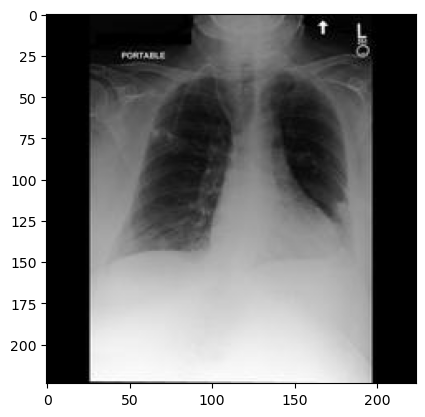

In [834]:
for item in train_dl:
    print(item['input_ids'].shape)
    print(item['pixel_values'].shape)
    break
show_data(item)

In [835]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
#config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch16")
#vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16", config=config.vision_config)

loading configuration file config.json from cache at /home/andrew/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/e6a30b603a447e251fdaca1c3056b2a16cdfebeb/config.json
Model config CLIPVisionConfig {
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 768,
  "image_size": 224,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 32,
  "projection_dim": 512,
  "transformers_version": "4.24.0"
}

loading weights file pytorch_model.bin from cache at /home/andrew/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/snapshots/e6a30b603a447e251fdaca1c3056b2a16cdfebeb/pytorch_model.bin
Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.2.laye

In [836]:
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
#text_encoder = BertModel.from_pretrained("bert-base-uncased")

loading configuration file config.json from cache at /home/andrew/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/9b5e0380b37eac696b3ff68b5f319c554523971f/config.json
You are using a model of type bert to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Model config CLIPTextConfig {
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "dropout": 0.0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "clip_text_model",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /home/andrew/.ca

In [837]:
def clip_wrapper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }

    #DUMMY_CONFIG = CLIPConfig(text_config_dict=config,vision_config_dict=config)
    DUMMY_CONFIG = CLIPConfig(
        text_config_dict = config,
        vision_config_dict = config
    )

    clip = CLIPModel(config=DUMMY_CONFIG)

    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()

    return clip


In [838]:
#text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
#text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

clip = clip_wrapper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder

In [839]:
text_encoder.config.hidden_size

768

In [840]:
vision_encoder.config.hidden_size

768

In [841]:
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

In [842]:
if __name__ == '__main__':
    out = clip(input_ids=item['input_ids'],
               attention_mask=item['attention_mask'],
               pixel_values=item['pixel_values'],
               return_loss=True)

    print('text and image embeddings: ',
          out.text_embeds.shape, out.image_embeds.shape)
    print('loss: ', out.loss)
    del out, item

text and image embeddings:  torch.Size([8, 768]) torch.Size([8, 768])
loss:  tensor(2.1012, grad_fn=<DivBackward0>)


## Trainer: train using huggingface trainer
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/train.py

In [843]:
from clip_classes import CLIPTrainer
from transformers.integrations import TensorBoardCallback

In [844]:
def train_model():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    helper.clear_gpu()
    args.dataloader_num_workers = helper.optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds,
                          callbacks = [TensorBoardCallback]
                         )

    trainer.train()

train_model()

    # save pretrained models
    # clip.text_model.save_pretrained('radCLIP')
    # tokenizer.save_pretrained('radCLIP')
    # clip.vision_model.save_pretrained('radCLIP')
    # vision_preprocessor.save_pretrained('radCLIP')

/home/andrew/miniconda3/envs/CLIP_demo/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 71866
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 44920
  Number of trainable parameters = 195174145


Step,Training Loss,Validation Loss
100,2.087900,2.087095
200,2.090700,2.077709
300,2.075000,2.072177
400,2.043700,2.058522
500,2.025000,2.040862
600,2.047000,2.018112
700,2.012300,2.007341
800,1.927700,1.971622
900,1.984000,1.963677
1000,1.947900,1.951097


***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evalua

In [ ]:
    # save pretrained models
    clip.text_model.save_pretrained('radCLIP4')
    tokenizer.save_pretrained('radCLIP4')
    clip.vision_model.save_pretrained('radCLIP4')
    vision_preprocessor.save_pretrained('radCLI4')

# Demo

## Utils: demo utils
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/utils.py

In [56]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

NameError: name 'Dataset' is not defined

## CLIPDemo
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/main.py

In [ ]:
TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT" #Need to load the finetuned one
IMAGE_MODEL = 'openai/clip-vit-base-patch32' #Need to load the finetuned one

In [ ]:
# There are original 
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)

In [ ]:
# Need to load the checkpoints


In [59]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = 32, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_embeddings_ = None
        self.image_embeddings_ = None
        

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ =  torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = ''):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        for i, sim in zip(indices, torch.softmax(values, dim=0)):
            print(
                f'label: {self.text[i]} | {round(float(sim), 3)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=25):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k/2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = '', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [58]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)
search.compute_image_embeddings(test_df.image.to_list())
search.compute_text_embeddings(['alveolar', 'pulmonary', 'edema', 'cardiomegaly', 'device'])

NameError: name 'vision_encoder' is not defined

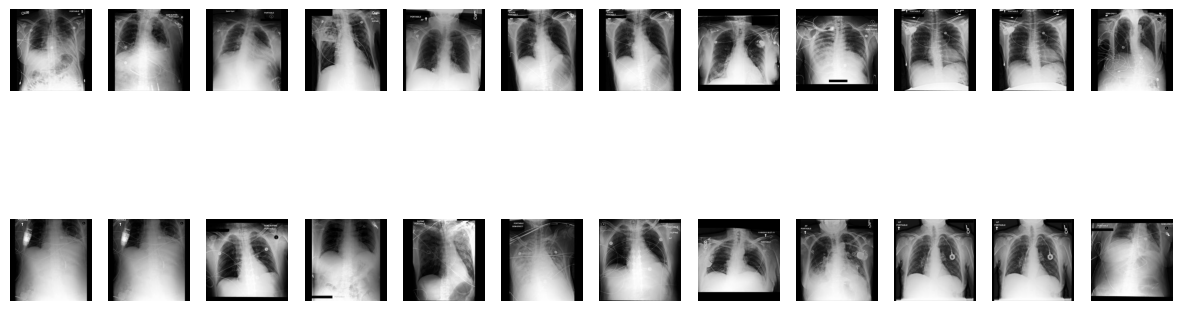

In [101]:
search.image_search('device')

In [108]:
test_df

,caption,image
81561,there is cephalization of vasculature with mil...,/media/andrew/HD-GDU3/498/train/train_resized/...
292345,small left pleural effusion is new.,/media/andrew/HD-GDU3/498/train/train_resized/...
312006,low lung volumes are noted at the current exam.,/media/andrew/HD-GDU3/498/train/train_resized/...
107058,no larger pleural effusions.,/media/andrew/HD-GDU3/498/train/train_resized/...
300852,lungs are clear without focal consolidation.,/media/andrew/HD-GDU3/498/train/train_resized/...
...,...,...
74110,the pulmonary vasculature is normal.,/media/andrew/HD-GDU3/498/train/train_resized/...
136950,no ptx detected.,/media/andrew/HD-GDU3/498/train/train_resized/...
116647,bibasal areas of atelectasis are unchanged.,/media/andrew/HD-GDU3/498/train/train_resized/...
57054,ett terminates appropriately m above carina.,/media/andrew/HD-GDU3/498/train/train_resized/...


In [109]:
test_df["caption"][81561]

'there is cephalization of vasculature with mild cardiomegaly and likely small left pleural effusion with compressive atelectasis.'

label: cardiomegaly | 0.217
label: edema | 0.216
label: pulmonary | 0.208
label: alveolar | 0.18
label: device | 0.179


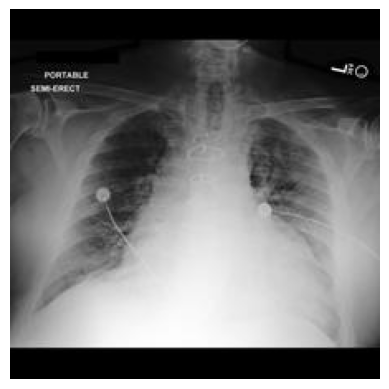

In [110]:
search.zero_shot(f'{test_df["image"][81561]}')

In [106]:
loc = test_df['image'][254]

KeyError: 254

In [ ]:
search.analogy(f'{test["image"][100]}')

## Old Code

In [ ]:
folder = "/media/andrew/HD-GDU3/498/train/"
dataset = "preprocess_metadata_train.csv"
#dataset = "train.csv"
location = folder + dataset

In [ ]:
imageset = pd.read_csv(location)
imageset.head()

In [384]:
#os.path.split(imageset['resized_img_path'][0])[1]
os.path.split(imageset['image'][0])[1]

'ff0ef993-08b09d98-34d71241-01bb236a-6e71ef75.jpg'

In [390]:
os.path.split(imageset['resized_img_path'][1])[1]

'19869118_56152811_54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7.jpg'

In [343]:
folder

'/media/andrew/HD-GDU3/498/train/'

In [354]:
combine_texts(268, db=reports, as_sentences=False)

'comparison to . the patient has been extubated and the nasogastric tube was removed. moderate cardiomegaly persists. the pacemaker is in stable position. also stable is the left-sided swan-ganz catheter. no pulmonary edema, minimal atelectasis at the right lung basis is stable.'

In [360]:
reports.loc[reports['study_id'] == 57540554].index[0]

76059

In [361]:
combine_texts(reports.loc[reports['study_id'] == 57540554].index[0], db=reports, as_sentences=False)

'the cardiomediastinal and hilar contours are within normal limits. the lungs are well expanded and clear. there is no large pleural effusion, pneumothorax or focal consolidation concerning for pneumonia. there is no evidence of free air. no acute cardiopulmonary process. no evidence of free air.'

In [365]:
imageset

,dicom_id,subject_id,study_id,orig_img_path,orig_img_height,orig_img_width,crop_img_path,crop_img_height,crop_img_width,padded_img_path,padding_delta_height,padding_delta_width,padded_img_height,padded_img_width,resized_img_path,resized_img_height,resized_img_width
0,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
1,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
2,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
3,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
4,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57579,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57580,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57581,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57582,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224


In [13]:
for item in range(0, len(datasat_nest.sentences)):
    for child in range(0, len(datasat_nest.sentences[item])):
        record = create_record(
            location = location, 
            caption = str(datasat_nest.sentences[item][child]['raw']).lower(),
            image = str(datasat_nest.sentences[item][child]['imgid']+1)+'.jpeg'
        )
        satnet = pd.concat([satnet, record],ignore_index=True)
#datasat_nest.sentences[1][1]['raw']

In [6]:
with open(location, 'r') as f:
    data = json.loads(f.read())
datasat_nest = pd.json_normalize(data, record_path=['images'])

In [7]:
datasat_nest.sentences[0]

[{'tokens': ['There', 'is', 'a', 'piece', 'of', 'formland'],
  'raw': 'There is a piece of farmland .',
  'imgid': 0,
  'sentid': 0},
 {'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'There is a piece of cropland .',
  'imgid': 0,
  'sentid': 1},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'It is a piece of farmland .',
  'imgid': 0,
  'sentid': 2},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'It is a piece of cropland .',
  'imgid': 0,
  'sentid': 3},
 {'tokens': ['Here', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'Here is a piece of farmland .',
  'imgid': 0,
  'sentid': 4}]

In [8]:
len(datasat_nest.sentences)

2100

In [9]:
datasat_nest.sentences[572]

[{'tokens': ['This', 'is', 'a', 'chaparral'],
  'raw': 'This is a chaparral .',
  'imgid': 572,
  'sentid': 2860},
 {'tokens': ['Lots', 'of', 'plants', 'scattered', 'on', 'the', 'ground.'],
  'raw': 'Lots of plants scattered on the ground. .',
  'imgid': 572,
  'sentid': 2861},
 {'tokens': ['Lots',
   'of',
   'plants',
   'scattered',
   'in',
   'the',
   'loess',
   'ground.'],
  'raw': 'Lots of plants scattered in the loess ground. .',
  'imgid': 572,
  'sentid': 2862},
 {'tokens': ['There',
   'are',
   'some',
   'grey',
   'plants',
   'scattered',
   'on',
   'the',
   'ground'],
  'raw': 'There are some grey plants scattered on the ground .',
  'imgid': 572,
  'sentid': 2863},
 {'tokens': ['Some',
   'grey',
   'plants',
   'are',
   'scattered',
   'in',
   'the',
   'loess',
   'ground'],
  'raw': 'Some grey plants are scattered in the loess ground .',
  'imgid': 572,
  'sentid': 2864}]

In [10]:
datasat_nest.sentences[1][1]

{'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
 'raw': 'There is a piece of cropland .',
 'imgid': 1,
 'sentid': 6}

In [13]:
for item in range(0, len(datasat_nest.sentences)):
    for child in range(0, len(datasat_nest.sentences[item])):
        record = create_record(
            location = location, 
            caption = str(datasat_nest.sentences[item][child]['raw']).lower(),
            image = str(datasat_nest.sentences[item][child]['imgid']+1)+'.jpeg'
        )
        satnet = pd.concat([satnet, record],ignore_index=True)
#datasat_nest.sentences[1][1]['raw']

In [14]:
satnet.tail()

,caption,image
10495,four tennis courts on the lawn with a road bes...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10496,four tennis courts are on the lawn and a road ...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10497,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10498,there are four tennis courts on the lawn and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10499,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg


In [15]:
satnet.dropna().to_csv('../CLIP_demo/dataset_sat.csv', index=False)